In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, TFSegformerForSemanticSegmentation
import pandas as pd
import cv2
import numpy as np
# import albumentations as aug

In [2]:
WIDTH = 640
HEIGHT = 480
dataset_path = 'SUIM_sam_100'
output_path = 'test_predictions_sam_100'

In [3]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "labels")

        print(self.img_dir)
        print(self.ann_dir)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Construct paths to the image and annotation
        image_path = os.path.join(self.img_dir, self.images[idx])
        annotation_path = os.path.join(self.ann_dir, self.annotations[idx])

        # Read the image and annotation using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        segmentation_map = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)

        # Dictionary mapping original IDs to new class IDs
        num2id = {0: 26, 1: 0, 2: 29, 3: 150, 4: 179, 5: 76, 6: 105, 7: 226, 8: 255}
        id_values = np.array(list(num2id.values()))
        id_keys = np.array(list(num2id.keys()))

        # Function to find the key of the closest value in num2id values
        def find_closest_key(value, id_values, id_keys):
            index = np.abs(id_values - value).argmin()
            return id_keys[index]

        # Create a mapping for each unique value in segmentation_map to the key of its closest value in num2id values
        unique_values = np.unique(segmentation_map)
        closest_key_mapping = {val: find_closest_key(val, id_values, id_keys) for val in unique_values}

        # Transform segmentation_map to have the keys corresponding to the closest num2id values
        converted_map = np.copy(segmentation_map)
        for original, closest_key in closest_key_mapping.items():
            converted_map[segmentation_map == original] = closest_key

        # Update segmentation_map with the converted_map
        segmentation_map = converted_map
        
        # Convert the OpenCV image to a PIL Image for the transformation
        image = Image.fromarray(image)
        segmentation_map = Image.fromarray(segmentation_map)

        # Resize the image and segmentation map to a fixed size, e.g., 640x480
        image = TF.resize(image, (HEIGHT, WIDTH))
        segmentation_map = TF.resize(segmentation_map, (HEIGHT, WIDTH), interpolation=TF.InterpolationMode.NEAREST)

        # Apply the transformations if any
        if self.transforms is not None:
            image = self.transforms(image)
        else:
            # Convert the PIL Image to a tensor (this also permutes dimensions to C x H x W)
            image = TF.to_tensor(image)

        # Convert the PIL Image back to a NumPy array if your processing pipeline requires it
        segmentation_map = np.array(segmentation_map)

        # Convert the segmentation map to a tensor
        segmentation_map = torch.tensor(segmentation_map, dtype=torch.long)


        # Prepare the return dictionary
        return_dict = {'pixel_values': image, 'labels': segmentation_map}

        # Include the filename in the return dictionary if not in training mode
        # Inside your method, after checking if not in training mode
        if not self.train:
            with Image.open(image_path) as img:
                width, height = img.size
            return_dict['filename'] = self.images[idx]
            return_dict['dim'] = (width, height)

        return return_dict

In [4]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.05),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])

In [5]:
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=dataset_path, feature_extractor=feature_extractor, transforms=transform)
test_dataset = ImageSegmentationDataset(root_dir=dataset_path, feature_extractor=feature_extractor, transforms=None, train=False)

SUIM_sam_100/train/images
SUIM_sam_100/train/labels
SUIM_sam_100/test/images
SUIM_sam_100/test/labels


/home/cesar/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/models/segformer/feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(test_dataset))

Number of training examples: 1525
Number of validation examples: 110


In [7]:
encoded_inputs = train_dataset[1]
encoded_inputs["pixel_values"].shape

torch.Size([3, 480, 640])

In [8]:
encoded_inputs["labels"].shape

torch.Size([480, 640])

In [9]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [4, 4, 4,  ..., 1, 1, 1],
        [4, 4, 4,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [10]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1, 2, 4])

In [11]:
mask = encoded_inputs["labels"].numpy()

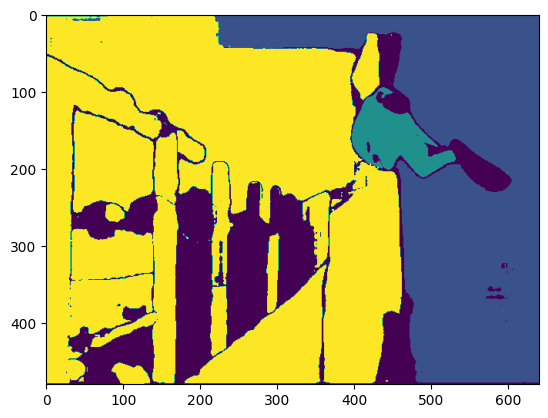

In [12]:
import matplotlib.pyplot as plt
plt.imshow(mask)

In [13]:
from torch.utils.data import DataLoader, random_split

total_size = len(train_dataset)
train_size = int(total_size * 0.8)  # 80% for training
validation_size = total_size - train_size  # 20% for validation

# Splitting the dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Creating DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(validation_dataset, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [14]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 480, 640])
labels torch.Size([4, 480, 640])


In [15]:
batch["labels"]

tensor([[[6, 6, 6,  ..., 6, 6, 6],
         [6, 6, 6,  ..., 6, 6, 6],
         [6, 6, 6,  ..., 6, 6, 6],
         ...,
         [8, 8, 8,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 4, 4, 4],
         [0, 0, 0,  ..., 4, 4, 4],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [4, 4, 4,  ..., 0, 0, 0],
         [4, 4, 4,  ..., 1, 1, 1],
         ...,
         [4, 4, 4,  ..., 0, 0, 0],
         [4, 4, 4,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [16]:
id2label = {0: "backgrond", 1: "BW", 2: "HD", 3: "PF", 4: "WR", 5: "RO", 6: "RI", 7: "FV", 8: "SR"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

In [17]:
model_checkpoint = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    reshape_last_stage=True,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.bias', 'decode_head.line

In [18]:
optimizer = AdamW(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/home/cesar/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Model Initialized!


In [19]:
num_epochs = 15
for epoch in range(1, num_epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        
        #print unique labels
        

        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # pixel_values = pixel_values.permute(0, 3, 1, 2)

        # print(pixel_values.shape)
        # print(pixel_values.dtype)
        # print(labels.shape)
        # print(labels.dtype)

        # check that all labels values are within the range of the number of classes
        assert torch.all(labels < num_labels), "A label value is out of the range of the number of classes."

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 0) # we don't include the background class in the accuracy calculation
        # Check if the mask is not empty
        # print(labels)
        if mask.any():
            pred_labels = predicted[mask].detach().cpu().numpy()
            true_labels = labels[mask].detach().cpu().numpy()
            accuracy = accuracy_score(pred_labels, true_labels)
        else:
            print("Warning: No valid labels found for accuracy calculation.")
            accuracy = 0
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 0) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")
    
# Save the model
torch.save(model.state_dict(), dataset_path+".pth")

Epoch: 1


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.6283456053342167         Train Loss: 1.2760157895869897         Val Pixel-wise accuracy: 0.7207757441249029         Val Loss: 1.059093033338522
Epoch: 2


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7134209495569769         Train Loss: 0.9887924553918057         Val Pixel-wise accuracy: 0.7522246821039233         Val Loss: 0.8933139404693207
Epoch: 3


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7376477123213678         Train Loss: 0.9040064313372628         Val Pixel-wise accuracy: 0.7720441176061644         Val Loss: 0.8317561563733337
Epoch: 4


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7680827611008227         Train Loss: 0.8235802787249206         Val Pixel-wise accuracy: 0.7359125570146294         Val Loss: 0.834580774818148
Epoch: 5


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7791098694972969         Train Loss: 0.7893465166209174         Val Pixel-wise accuracy: 0.7693273903316395         Val Loss: 0.8214889935084752
Epoch: 6


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.7991465441700523         Train Loss: 0.7341501436272605         Val Pixel-wise accuracy: 0.7846829951987259         Val Loss: 0.8157203452927726
Epoch: 7


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8043376092769084         Train Loss: 0.7102748221061269         Val Pixel-wise accuracy: 0.7596349223880247         Val Loss: 0.7802315605925275
Epoch: 8


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.82265545633928         Train Loss: 0.6736688208384592         Val Pixel-wise accuracy: 0.773466467086601         Val Loss: 0.8068329204212535
Epoch: 9


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8336386274874775         Train Loss: 0.6416657319811524         Val Pixel-wise accuracy: 0.7396611295242386         Val Loss: 0.8450492299222326
Epoch: 10


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8348341476065668         Train Loss: 0.629340613767749         Val Pixel-wise accuracy: 0.7855113211404271         Val Loss: 0.8424081860424636
Epoch: 11


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8451699256677335         Train Loss: 0.5970665307318578         Val Pixel-wise accuracy: 0.7767284657160203         Val Loss: 0.8458390224289585
Epoch: 12


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8439189497830824         Train Loss: 0.6025602542963184         Val Pixel-wise accuracy: 0.7647331499562988         Val Loss: 0.8608848038431886
Epoch: 13


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8491811986657307         Train Loss: 0.5810517741031334         Val Pixel-wise accuracy: 0.7878572544722101         Val Loss: 0.9114397214604663
Epoch: 14


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8588571784552366         Train Loss: 0.5600208632281569         Val Pixel-wise accuracy: 0.791423897292252         Val Loss: 0.832599663115167
Epoch: 15


  0%|          | 0/305 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8612414192173761         Train Loss: 0.543833997894506         Val Pixel-wise accuracy: 0.7583781899396113         Val Loss: 0.9079811333061812


PREDICT IN TEST IMAGES

In [20]:
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn

In [21]:
id2label = {0: "backgrond", 1: "BW", 2: "HD", 3: "PF", 4: "WR", 5: "RO", 6: "RI", 7: "FV", 8: "SR"}
palette = [[64, 0, 64], [0, 0, 0], [0, 0, 255], [0, 255, 0], [0, 255, 255], [255, 0, 0], [255, 0, 255], [255, 255, 0], [255, 255, 255]]
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

In [22]:
# Predict in test images
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    reshape_last_stage=True,
)

# Load the model weights
checkpoint = torch.load(dataset_path+".pth", map_location=device)
model.load_state_dict(checkpoint)

model = model.to(device)


/home/cesar/miniconda3/envs/mmlab/lib/python3.7/site-packages/transformers/models/segformer/feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemantic

In [23]:
model.eval()

def rescale_image(image, new_shape):
    return cv2.resize(image, (new_shape[1], new_shape[0]), interpolation=cv2.INTER_NEAREST)

def get_predictions(predictions_numpy, batch):
    # Get the image sizes
    original_shape = batch['pixel_values'].shape[-2:]
    
    # Rescale the predictions to the original image size
    rescaled_predictions = [rescale_image(prediction, original_shape) for prediction in predictions_numpy]
    
    # Convert list of rescaled predictions to a NumPy array
    rescaled_predictions = np.array(rescaled_predictions)
    
    # Get the original images and labels
    images = batch['pixel_values'].cpu().numpy()
    images = images.transpose(0, 2, 3, 1)
    labels = batch['labels'].cpu().numpy()

    return images, labels, rescaled_predictions

# Plot the images, labels, and predictions
def plot_predictions(images, labels, predictions):
    fig, axs = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
    for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(label)
        axs[i, 1].set_title("Label")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(prediction)
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

def label_to_rgb(label, palette):
    # Create an empty image with 3 channels for RGB
    rgb_image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    
    # Map each label to its corresponding color
    for i, color in enumerate(palette):
        mask = (label == i)
        rgb_image[mask] = color
    
    return rgb_image

def convert_predictions_and_labels_to_rgb(labels, predictions, palette):
    labels_rgb = np.array([label_to_rgb(label, palette) for label in labels])
    predictions_rgb = np.array([label_to_rgb(prediction, palette) for prediction in predictions])
    return labels_rgb, predictions_rgb

all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch['pixel_values'].to(device)
        filenames = batch['filename']
        dims = batch['dim']

        widths, heights = dims
        widths_list = widths.tolist()
        heights_list = heights.tolist()
        dims_tuples = list(zip(widths_list, heights_list))
        
        # Get model predictions
        outputs = model(inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        
        # Move predictions to CPU and convert to numpy for further processing if necessary
        predictions_numpy = predicted_labels.cpu().numpy()

        # Process and plot predictions for the current batch
        images, labels, rescaled_predictions = get_predictions(predictions_numpy, batch)

        # Labels and predictions to RGB with palette
        labels_rgb, predictions_rgb = convert_predictions_and_labels_to_rgb(labels, rescaled_predictions, palette)

        for filename, prediction_rgb, dim in zip(filenames, predictions_rgb, dims_tuples):
            all_predictions.append((filename, prediction_rgb, dim))

# Reshape all predicitons to the original image size

output_dir = output_path
os.makedirs(output_dir, exist_ok=True)

for filename, prediction, dim in all_predictions:  # Adjusted to unpack filenames with predictions
    # Reshape prediction to the original image size
    prediction = cv2.resize(prediction, dim, interpolation=cv2.INTER_NEAREST)
    output_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')  # Use original filename
    cv2.imwrite(output_path, cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR))